<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/Hidden_Markov_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [136]:
#!pip install hmmlearn
#!pip install yfinance

In [137]:
from hmmlearn import hmm
import yfinance as yf

In [138]:
df = yf.download('^NSEI',start='2015-01-01')

[*********************100%***********************]  1 of 1 completed


In [139]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(1)

In [140]:
#df = pd.read_csv('SPY.csv', index_col='Date', parse_dates=True)

In [141]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,8288.700195,8410.599609,8288.700195,8395.450195,8395.450195,101900
2015-01-05,8407.950195,8445.599609,8363.900391,8378.400391,8378.400391,118200
2015-01-06,8325.299805,8327.849609,8111.350098,8127.350098,8127.350098,172800
2015-01-07,8118.649902,8151.200195,8065.450195,8102.100098,8102.100098,164100
2015-01-08,8191.399902,8243.500000,8167.299805,8234.599609,8234.599609,143800


In [142]:
returns = np.log(df['Close']).diff(7)

In [143]:
returns.dropna(inplace=True)

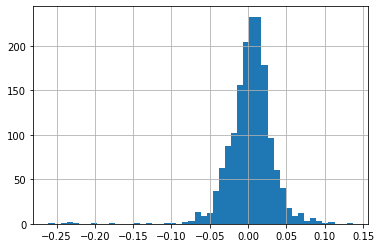

In [144]:
returns.hist(bins=50);

In [145]:
model = hmm.GaussianHMM(n_components=2, covariance_type="diag")

In [146]:
X = returns.to_numpy().reshape(-1, 1)
model.fit(X)

GaussianHMM(algorithm='viterbi', covariance_type='diag', covars_prior=0.01,
            covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
            min_covar=0.001, n_components=2, n_iter=10, params='stmc',
            random_state=None, startprob_prior=1.0, tol=0.01,
            transmat_prior=1.0, verbose=False)

In [147]:
Z = model.predict(X)

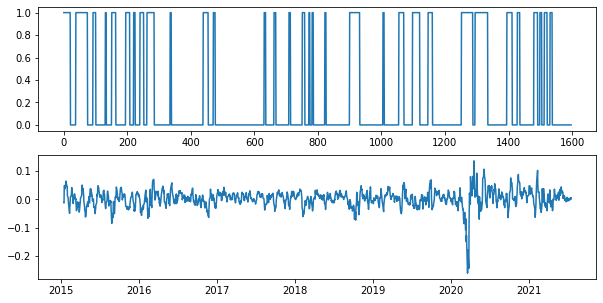

In [148]:
fig, ax = plt.subplots(figsize=(10, 5))
plt.subplot(211)
plt.plot(Z)
plt.subplot(212)
plt.plot(returns);

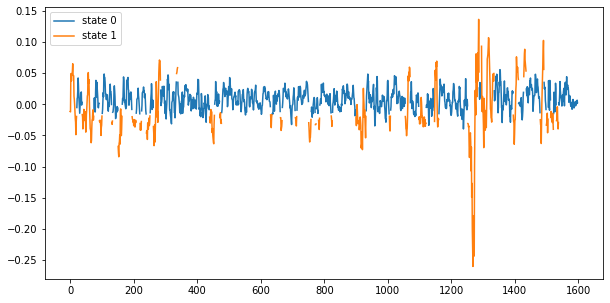

In [149]:
# we want to draw different segments in different colors according to state
fig, ax = plt.subplots(figsize=(10, 5))

# first create arrays with nan
returns0 = np.empty(len(Z))
returns1 = np.empty(len(Z))
returns0[:] = np.nan
returns1[:] = np.nan

# fill in the values only if the state is the one corresponding to the array
returns0[Z == 0] = returns[Z == 0]
returns1[Z == 1] = returns[Z == 1]
plt.plot(returns0, label='state 0')
plt.plot(returns1, label='state 1')
plt.legend();

In [150]:
# transition matrix
model.transmat_

array([[0.956021  , 0.043979  ],
       [0.11149843, 0.88850157]])

In [151]:
# try to set the transition matrix intuitively
model.transmat_ = np.array([
  [0.999, 0.001],
  [0.001, 0.999],                           
])

In [152]:
# run inference again
Z = model.predict(X)
ret=returns.reset_index()
zi= pd.concat([ret.Date,pd.Series(Z)],axis=1)
zi=zi.set_index('Date')
zi.columns=['pred']



In [153]:
def plot_buy_sell_signal(df):
  reg1=[]
  reg2=[]
  for i in range(len(df)):
    if df.pred.iloc[i]==1 and df.pred.iloc[i-1]==0 :
      reg1.append(i)
    elif df.pred.iloc[i]==0 and df.pred.iloc[i-1]==1 :
      reg2.append(i)
  
  return reg1,reg2

In [154]:
sell,buy=plot_buy_sell_signal(zi)

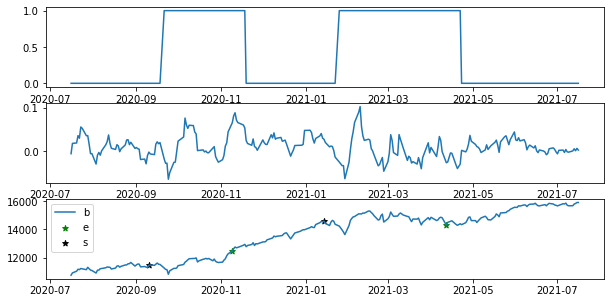

In [168]:
fig, ax = plt.subplots(figsize=(10, 5),sharex=True)
plt.subplot(311)
plt.plot(zi[-250:])
plt.subplot(312)
plt.plot(returns[-250:])
plt.subplot(313)
plt.plot(df['Close'][-250:])
plt.scatter(df.iloc[buy][-2:].index,df.iloc[buy][-2:].Close,marker='*',color='g',label='Regime 1')
plt.scatter(df.iloc[sell][-2:].index,df.iloc[sell][-2:].Close,marker='*',color='black',label=' Regime 2')
plt.plot(label='Regime 1')
plt.plot(label='Regime 2')
plt.legend('best')
plt.show();

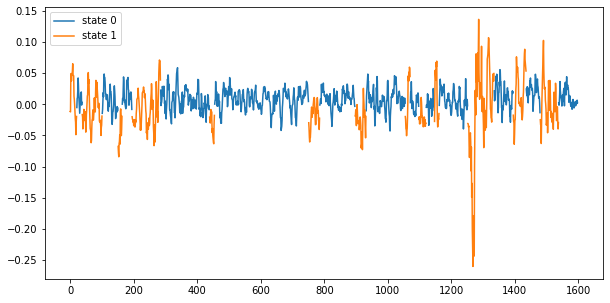

In [156]:
# we want to draw different segments in different colors according to state
fig, ax = plt.subplots(figsize=(10, 5))

# first create arrays with nan
returns0 = np.empty(len(Z))
returns1 = np.empty(len(Z))
returns0[:] = np.nan
returns1[:] = np.nan

# fill in the values only if the state is the one corresponding to the array
returns0[Z == 0] = returns[Z == 0]
returns1[Z == 1] = returns[Z == 1]
plt.plot(returns0, label='state 0')
plt.plot(returns1, label='state 1')
plt.legend();